In [1]:
# %% [markdown]
# # Step 0 (revised): Extract Aggregated Metrics from the Log

# %%
import re
import pandas as pd

# 1) read log lines
log_path = "REVISED.txt"
with open(log_path, "r") as f:
    lines = [l.rstrip("\n") for l in f]

# 2) compile our three regexes (no longer anchored to start of line)
agg_header = re.compile(r"\*\*\* AGGREGATED \[(?P<model>.+?)\] for '(?P<group>.+?)' \*\*\*")
metrics_re = re.compile(r"TP=(?P<tp>\d+), FP=(?P<fp>\d+), FN=(?P<fn>\d+), TN=(?P<tn>\d+)")
scores_re  = re.compile(r"Precision=(?P<precision>\d+\.\d+), Recall=(?P<recall>\d+\.\d+), F1=(?P<f1>\d+\.\d+), Accuracy=(?P<accuracy>\d+\.\d+)")

# 3) walk through lines and collect records using .search()
records = []
current = None
for line in lines:
    m = agg_header.search(line)
    if m:
        current = {"model": m.group("model"), "group": m.group("group")}
        continue
    if current:
        mm = metrics_re.search(line)
        if mm:
            current.update({k:int(v) for k,v in mm.groupdict().items()})
            continue
        ms = scores_re.search(line)
        if ms:
            current.update({k:float(v) for k,v in ms.groupdict().items()})
            records.append(current)
            current = None

# 4) turn into DataFrame
df_agg = pd.DataFrame(records)

# 5) sanity check and export
print(df_agg.head(5))
df_agg.to_csv("aggregated_metrics.csv", index=False)



         model                                       group  tp  fp  fn  tn  \
0          GMM       Variant - Two clearly separated peaks   0   0   0  10   
1  RidgeWalker       Variant - Two clearly separated peaks   0   0   0  10   
2      Wavelet       Variant - Two clearly separated peaks   0   0   0  10   
3          GMM  Variant - Strong overlap between two peaks   2   0   3   0   
4  RidgeWalker  Variant - Strong overlap between two peaks   5   0   0   0   

   precision  recall    f1  accuracy  
0        1.0     1.0  1.00       1.0  
1        1.0     1.0  1.00       1.0  
2        1.0     1.0  1.00       1.0  
3        1.0     0.4  0.57       0.4  
4        1.0     1.0  1.00       1.0  


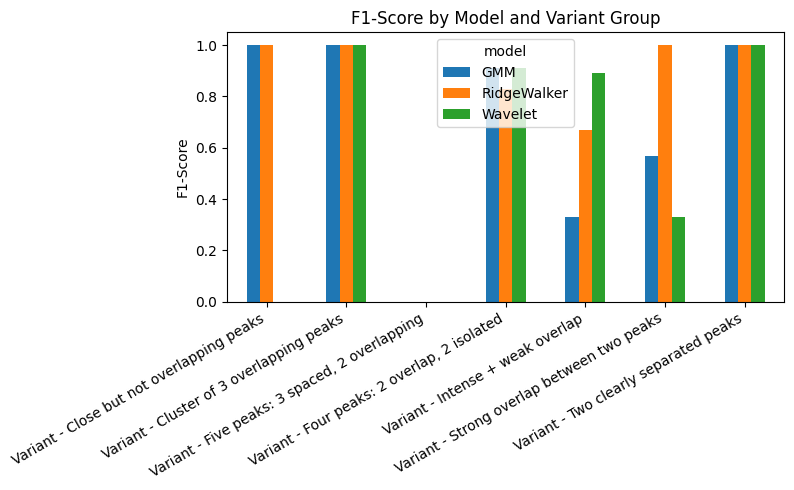

In [75]:
# Step 2: Pivot the F1‐scores by group × model and plot them
import matplotlib.pyplot as plt

# reload if you want to start fresh
agg = pd.read_csv("aggregated_metrics.csv")

# pivot out the F1‐scores
f1_table = agg.pivot(index="group", columns="model", values="f1")

# plot
ax = f1_table.plot(kind="bar", figsize=(8,5))
ax.set_title("F1‐Score by Model and Variant Group")
ax.set_ylabel("F1‐Score")
ax.set_xlabel("")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


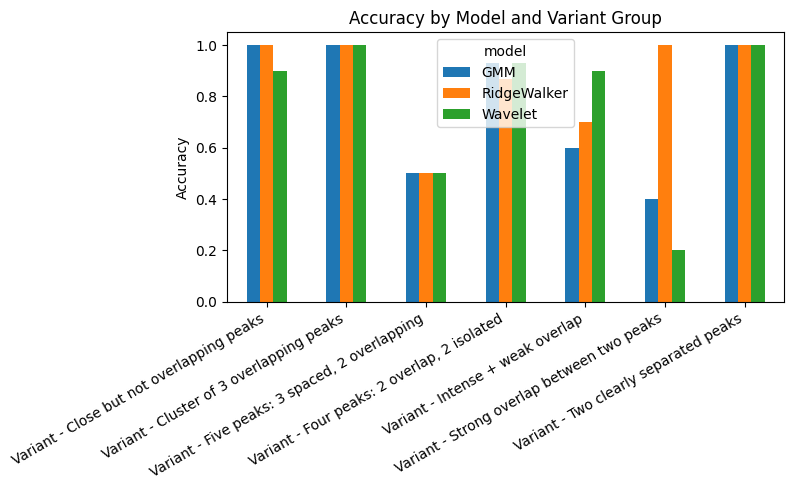

In [76]:
# Step 3: Plot Accuracy by Model and Variant Group

import matplotlib.pyplot as plt

# pivot out the accuracy values
acc_table = agg.pivot(index="group", columns="model", values="accuracy")

# plot
ax = acc_table.plot(kind="bar", figsize=(8,5))
ax.set_title("Accuracy by Model and Variant Group")
ax.set_ylabel("Accuracy")
ax.set_xlabel("")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


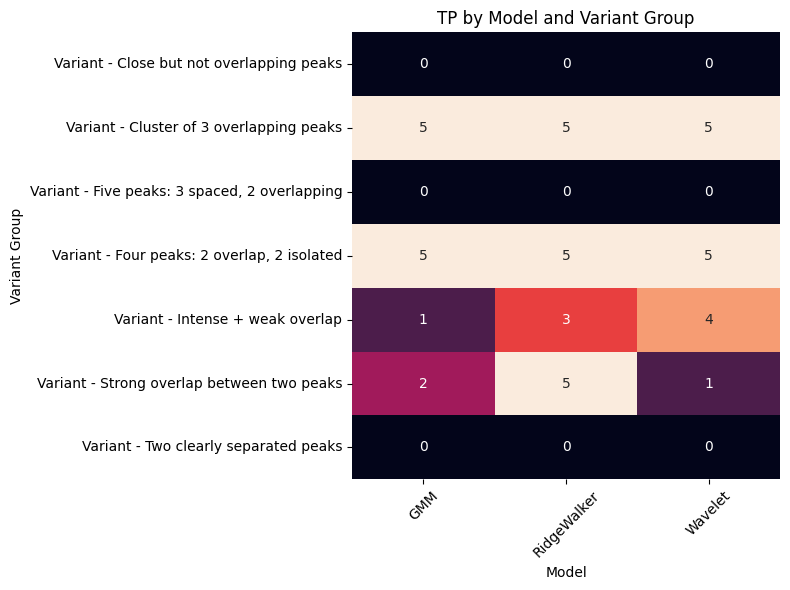

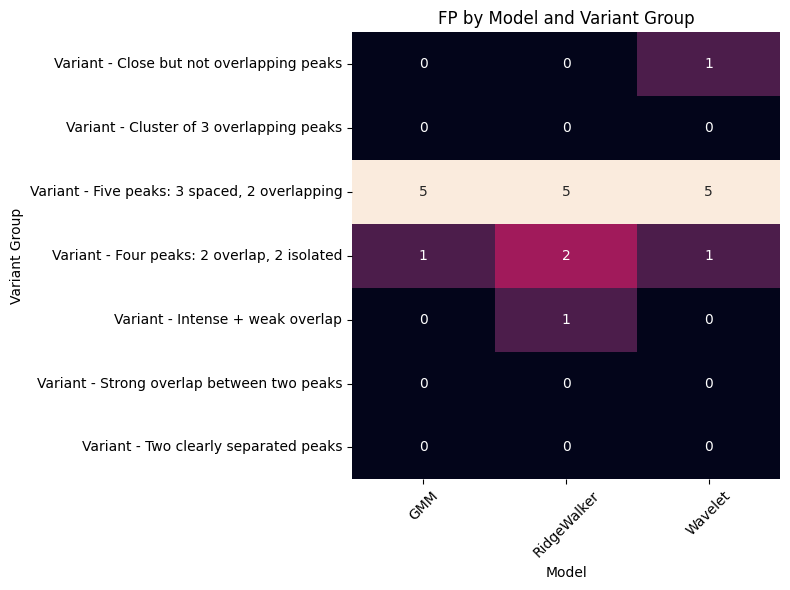

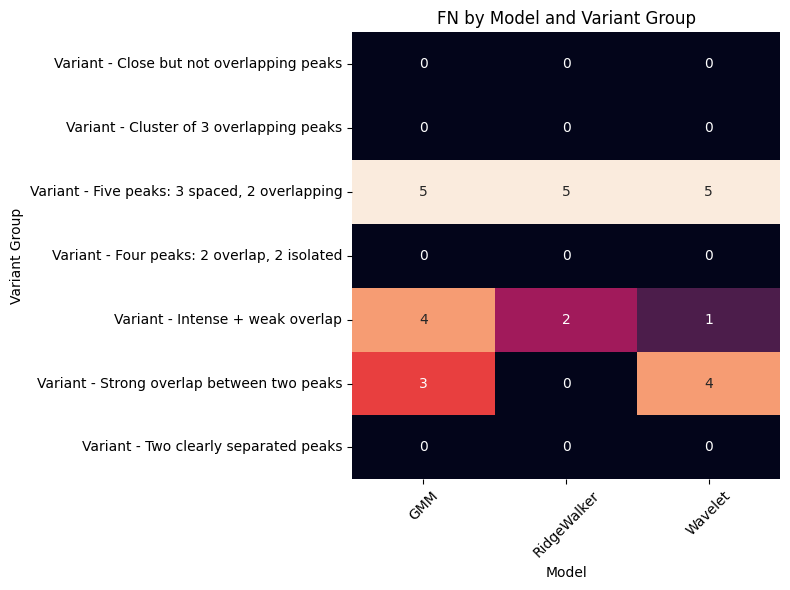

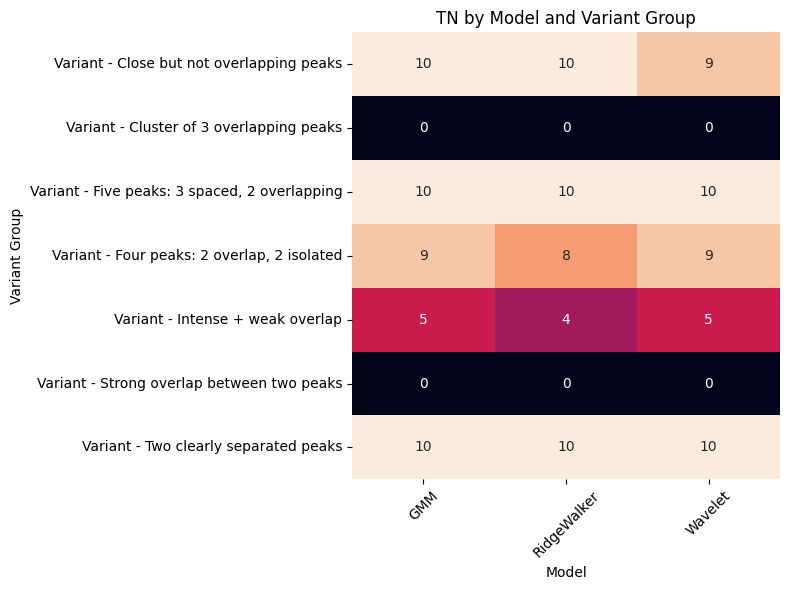

In [77]:
# Next Step: Plot each confusion‐matrix metric in its own full‐width figure

import seaborn as sns
import matplotlib.pyplot as plt

# assume `agg` is your DataFrame with columns:
# ['group','model','tp','fp','fn','tn','precision','recall','f1','accuracy']

# Melt to long format once
cm_long = agg.melt(
    id_vars=['group','model'],
    value_vars=['tp','fp','fn','tn'],
    var_name='metric',
    value_name='count'
)

# For each metric, make a separate heatmap
for metric in ['tp', 'fp', 'fn', 'tn']:
    pivot = (
        cm_long[cm_long['metric'] == metric]
        .pivot(index='group', columns='model', values='count')
        .fillna(0).astype(int)
    )
    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot, annot=True, fmt='d', cbar=False)
    plt.title(f'{metric.upper()} by Model and Variant Group')
    plt.ylabel('Variant Group')
    plt.xlabel('Model')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


In [78]:
["group", "model", "region_idx", "overlap_true", "overlap_pred", 
 "count_error", "mean_loc_error", "confidence"]


['group',
 'model',
 'region_idx',
 'overlap_true',
 'overlap_pred',
 'count_error',
 'mean_loc_error',
 'confidence']

In [79]:
# %% 
# Step 4: Load region‐level metrics
import pandas as pd

region = pd.read_csv("region_results.csv")
region.head()



,group,label,model,region_idx,overlap_true,overlap_pred,count_error,mean_loc_error,confidence
0,Variant - Two clearly separated peaks,Variant - Two clearly separated peaks 1,GMM,0,False,False,NaN,NaN,0.0
1,Variant - Two clearly separated peaks,Variant - Two clearly separated peaks 1,GMM,1,False,False,NaN,NaN,0.0
2,Variant - Two clearly separated peaks,Variant - Two clearly separated peaks 1,RidgeWalker,0,False,False,NaN,NaN,NaN
3,Variant - Two clearly separated peaks,Variant - Two clearly separated peaks 1,RidgeWalker,1,False,False,NaN,NaN,NaN
4,Variant - Two clearly separated peaks,Variant - Two clearly separated peaks 1,Wavelet,0,False,False,NaN,NaN,NaN


c:\Users\victo\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\victo\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\victo\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\victo\AppData\Local\Programs\Python\Python311

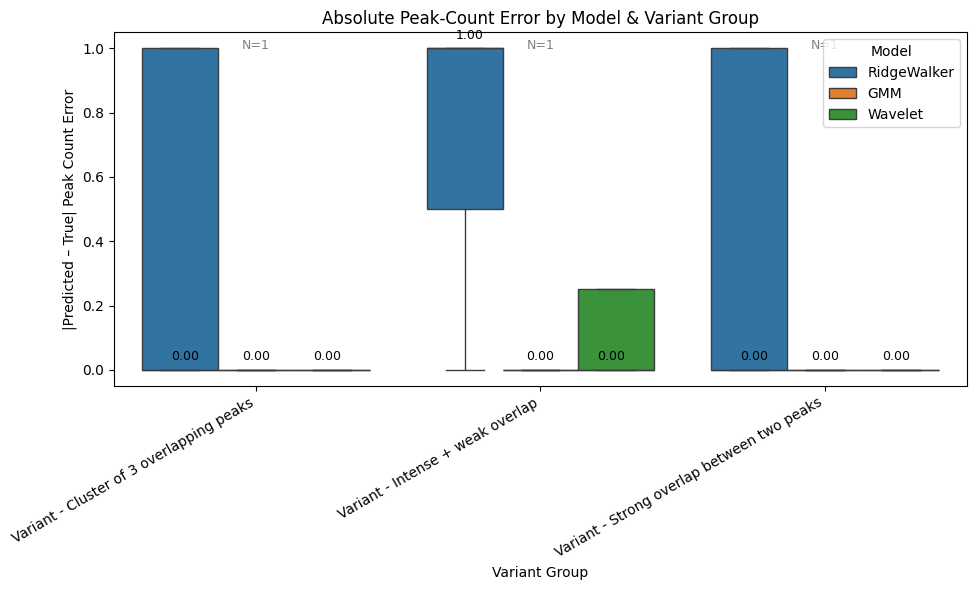

In [80]:
# Improved Peak‐Count Error box‐plot by Model × Variant Group
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# assume `region` is your DataFrame from region_results.csv
# 1) select only rows where we actually computed a count_error
pc = region.dropna(subset=["count_error"])

# 2) find which groups have at least one nonzero error
groups_with_error = pc.loc[pc["count_error"] > 0, "group"].unique()

# 3) filter to those groups
pc = pc[pc["group"].isin(groups_with_error)]

# 4) decide on an order for the Variant Groups (e.g. increasing median error)
group_order = (
    pc.groupby("group")["count_error"]
      .median()
      .sort_values(ascending=False)
      .index
      .tolist()
)

plt.figure(figsize=(10,6))
ax = sns.boxplot(
    data=pc,
    x="group",
    y="count_error",
    hue="model",
    order=group_order,
    showfliers=False
)

# 5) annotate median on each box
for i, model in enumerate(pc["model"].unique()):
    for j, grp in enumerate(group_order):
        med = pc.loc[
            (pc["model"] == model) & (pc["group"] == grp),
            "count_error"
        ].median()
        # calculate x-position: one box per model in each group
        x = j + (i - 1)*(0.25)  # adjust offset based on palette
        ax.text(x, med + 0.02, f"{med:.2f}", ha="center", va="bottom", fontsize=9)

# 6) annotate N (number of regions) above each group
counts = pc.groupby("group")["region_idx"].nunique().reindex(group_order)
for j, (grp, n) in enumerate(counts.items()):
    ax.text(j, ax.get_ylim()[1]*0.98, f"N={n}", ha="center", va="top", fontsize=9, color="gray")

plt.title("Absolute Peak‐Count Error by Model & Variant Group")
plt.xlabel("Variant Group")
plt.ylabel("|Predicted – True| Peak Count Error")
plt.xticks(rotation=30, ha="right")
plt.legend(title="Model", loc="upper right")
plt.tight_layout()
plt.show()



c:\Users\victo\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\victo\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\victo\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\victo\AppData\Local\Programs\Python\Python311

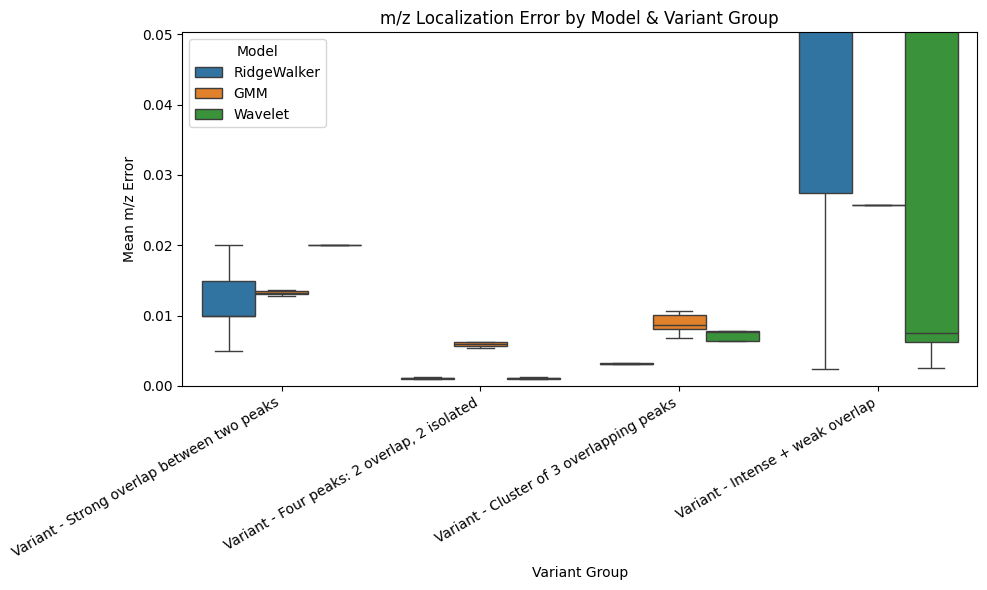

In [81]:
# Localization Error box‐plot by Model × Variant Group (only show groups with nonzero localization errors)

import matplotlib.pyplot as plt
import seaborn as sns

# 1) select only rows where we actually computed a mean_loc_error
le = region.dropna(subset=["mean_loc_error"])

# 2) find which groups have at least one nonzero localization error
groups_with_loc_error = le.loc[le["mean_loc_error"] > 0, "group"].unique()

# 3) filter to those groups
le = le[le["group"].isin(groups_with_loc_error)]

plt.figure(figsize=(10,6))
sns.boxplot(
    data=le,
    x="group",
    y="mean_loc_error",
    hue="model",
    showfliers=False
)
plt.title("m/z Localization Error by Model & Variant Group")
plt.xlabel("Variant Group")
plt.ylabel("Mean m/z Error")
plt.xticks(rotation=30, ha="right")
plt.legend(title="Model")
# optionally zoom in on the lower end to avoid a single outlier blowing up the scale:
plt.ylim(0, le["mean_loc_error"].quantile(0.95) * 1.1)
plt.tight_layout()
plt.show()


c:\Users\victo\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\victo\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


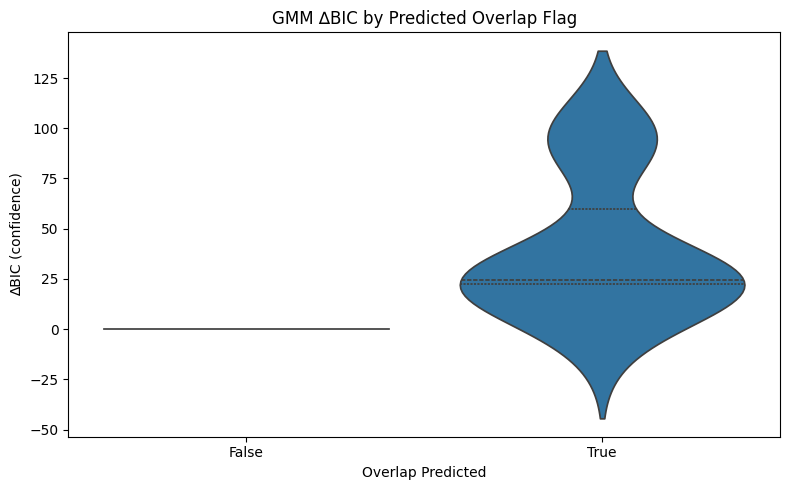

In [82]:
# %%
# Confidence distribution for true vs false overlap predictions (GMM)
g = region[region["model"] == "GMM"].copy()

plt.figure(figsize=(8,5))
sns.violinplot(
    data=g,
    x="overlap_pred",
    y="confidence",
    inner="quartile"
)
plt.title("GMM ∆BIC by Predicted Overlap Flag")
plt.xlabel("Overlap Predicted")
plt.ylabel("∆BIC (confidence)")
plt.xticks([0,1], ["False","True"])
plt.tight_layout()
plt.show()

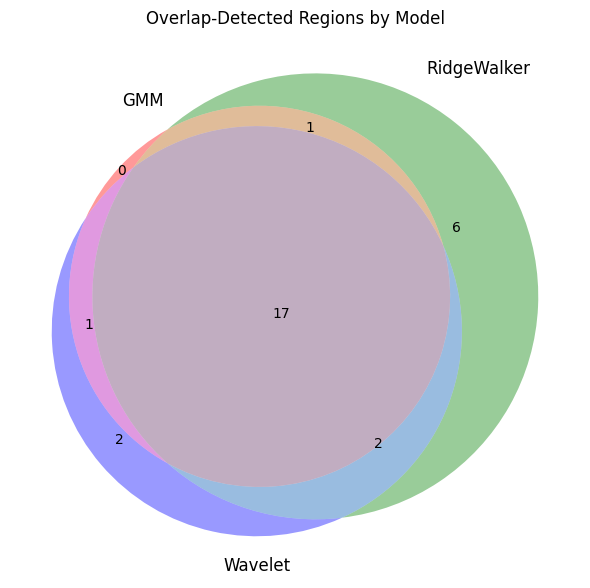

In [83]:
from matplotlib_venn import venn3

# build three sets of labels: (group,label,region_idx)
sets = {}
for m in ["GMM","RidgeWalker","Wavelet"]:
    detected = region[
        (region["model"]==m) &
        (region["overlap_pred"]==True)
    ]
    sets[m] = set( zip(detected.group, detected.label, detected.region_idx) )

plt.figure(figsize=(6,6))
venn3(
    [sets["GMM"], sets["RidgeWalker"], sets["Wavelet"]],
    set_labels=("GMM","RidgeWalker","Wavelet")
)
plt.title("Overlap‐Detected Regions by Model")
plt.tight_layout()
plt.show()
